## Prerequisites
 **LOCAL** Cytoscape (3.10.0 or greater) + **Local** Jupyter environment (including py4cytoscape).

### Setup required 

- Install Cytoscape on your PC. (See https://cytoscape.org/download.html)
- Install Jupyter on your PC. (See https://jupyter.org/install)
- Install py4cytoscape with `pip install py4cytoscape` on your PC.

## Getting started
**NOTE: To run this notebook, you must manually start Cytoscape first – don’t proceed until you have started Cytoscape.**

First, confirm that you have everything installed and running:

In [151]:
### necessary imports
import py4cytoscape as p4c
import os
from os.path import join, exists, dirname
import pandas as pd
from itertools import chain
import time
from datetime import date
import numpy as np
from collections import defaultdict
import re
### for showing examples and distribution figures
from IPython.display import Image, display
import matplotlib.pyplot as plt
from pprint import pprint


### checking that cytoscape is running - this should print out 'You are connected to Cytoscape!' 
### and the version of Cytoscape you are connected to
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.3',
 'automationAPIVersion': '1.11.0',
 'py4cytoscapeVersion': '1.11.0'}

# GOLDfinder results visualization
Start by specifying the input directory, that includes all files generated by GOLDfinder, and the output directory, where new files will be generated

In [152]:
### set input and output directories
currentdir = os.getcwd()
print("Current directory is: %s" %(currentdir))
examples_dir = join(dirname(currentdir), 'example_files')
### Using mini example here. if this command was run: 'python goldfinder/goldfinder.py -i example_files/matrix_mini_example.csv -t example_files/example.nwk -c both'
### then an 'output' folder has been created, which includes the goldfinder output files needed for the visualisation.
 
### Replace with your own paths
inputdir = join(dirname(currentdir), 'output')

### Let's generate the output in the same folder as the input for this example
outdir = inputdir

### make output folder if it doesn't exist already
if not exists(outdir):
    os.mkdir(outdir)
    print("Created folder: %s" %(outdir))

Current directory is: /home/agavriil/Documents/goldfinder_projects/goldfinder


## Visualisation styles
Importing premade styles from file. These are used in the examples below. Any custom styles would need to be imported first and then called in the relevant functions

In [153]:
### import styles file - this should be present in the same folder as the script
styles_file = os.path.join(currentdir,'GOLDfinder_custom_styles.xml')
#styles_file = join(currentdir, 'default_cy_styles.xml')

styles_dict = {'all_association':'GOLDfinder_allassoc', 
               'all_assoc_part_dissoc':'GOLDfinder_allassoc_partialDis',
               'all_assoc_genebased_dissoc':'GOLDfinder_allassoc_genebasedDis',
               'phage_defense_all_assoc':'GOLDfinder_phagedefense',
               'manuscript_comparison':'GOLDfinder-COINfinder_copycatFig1',
               'test':'default'}
### check if all the GOLDfinder styles are already imported in Cytoscape
styles = p4c.get_visual_style_names()
if not all([style in styles for style in styles_dict.values()]):
    print("Importing visual styles")
    p4c.import_visual_styles(styles_file)
styles_description_dict = {'all_association':'Networks that include MCL association clusters and their members, differentially showing cluster-cluster, cluster-gene and gene-gene edges.', 
                           'all_assoc_part_dissoc':'Same as all_association, but also includes member-member dissociation edges.',
                           'all_assoc_genebased_dissoc':'Same as all_association, but also includes gene-based dissociation edges (See details on GeneForce for more).',
                           'phage_defense_all_assoc':'Similar as all_association, but colours separately phage, defense, antidefense genes.',
                           'manuscript_comparison':'Style used in the GOLDfinder manuscript for the comparison of GOLDfinder and COINfinder results. Needs fixing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
                           'test':'Default style that already exists in Cytoscape'}
### checking layout names and tweakable attributes - uncomment one at a time
#p4c.get_layout_names()
#p4c.get_layout_property_names('attribute-circle')
#p4c.get_layout_property_names('force-directed')
#p4c.get_layout_name_mapping()

### Tweakable visual properties

In [154]:
# The colours are defined by hexadecimal codes. You can use a colour picker tool to find the code for the colour you want (e.g. http://medialab.github.io/iwanthue/)

# Commonly used node visual properties in Cytoscape
common_node_properties = [
    "NODE_FILL_COLOR",         # Color of the node
    "NODE_SHAPE",              # Shape of the node (DIAMOND, ELLIPSE, HEXAGON, OCTAGON, PARALLELOGRAM, RECTANGLE, ROUND_RECTANGLE, TRIANGLE, VEE)
    "NODE_SIZE",               # Size of the node (scales width and height together) (> 0)
    "NODE_LABEL",              # Text label for the node (default is the node name) 
    "NODE_LABEL_COLOR",        # Color of the node label
    "NODE_LABEL_FONT_SIZE",    # Font size of the node label (> 1)
    "NODE_BORDER_WIDTH",       # Width of the node's border (>= 0)
    "NODE_BORDER_COLOR",       # Color of the node's border
    "NODE_TRANSPARENCY",       # Transparency of the node (0-255)
    "NODE_LABEL_TRANSPARENCY", # Transparency of the node label (0-255)
]
print("Commonly used node properties:")
pprint(common_node_properties)

# Commonly used edge visual properties in Cytoscape
# Define a dictionary of commonly used edge properties with brief descriptions
common_edge_properties = [
    "EDGE_WIDTH",               # Width of the edge (> 0)
    "EDGE_COLOR",               # Color of the edge
    "EDGE_TRANSPARENCY",        # Transparency of the edge (0-255 where 0 is fully transparent)
    "EDGE_LABEL",               # Text label for the edge, empty by default
    "EDGE_LABEL_COLOR",         # Color of the edge label
    "EDGE_LABEL_FONT_SIZE",     # Font size of the edge label (> 1)
    "EDGE_LINE_TYPE",           # Line type (SOLID, DASHED, DOTTED, ZIGZAG, PARALLEL_LINES, SEPARATE_PARALLEL_LINES)
    "EDGE_SOURCE_ARROW_SHAPE",  # Arrow shape at the source end (NONE, ARROW, DIAMOND, CIRCLE, T, DELTA, HALF_ARROW_TOP, HALF_ARROW_BOTTOM)
    "EDGE_TARGET_ARROW_SHAPE",  # Arrow shape at the target end (NONE, ARROW, DIAMOND, CIRCLE, T, DELTA, HALF_ARROW_TOP, HALF_ARROW_BOTTOM)
    "EDGE_SOURCE_ARROW_COLOR",  # Arrow color at the source end
    "EDGE_TARGET_ARROW_COLOR"  # Arrow color at the target end
]
print("\nCommonly used edge properties:")
pprint(common_edge_properties)

# Get help on the map_visual_property function to see how to use it
#help(p4c.map_visual_property)

### Here is a list of all visual properties that can be modified. You can also look for specific properties for nodes, edges, and networks
#visual_properties = p4c.get_visual_property_names()
#node_properties = [prop for prop in visual_properties if 'NODE' in prop]
#print("\nAvailable node properties:")
#pprint(node_properties)
try:
    ### import network example in order to get the current visual style
    #p4c.import_network_from_file(join(examples_dir, 'network_mini_example.sif'))
    p4c.open_session(join(examples_dir, 'network_mini_example.cys'))
    style_details = p4c.get_current_style()     # Get the current visual style - only works if a network is loaded
    print(f"\nDetails for Visual Style default:")
    print(style_details)
except:
    print("\nNo network loaded. Please load a network to get the current visual style.")

Commonly used node properties:
['NODE_FILL_COLOR',
 'NODE_SHAPE',
 'NODE_SIZE',
 'NODE_LABEL',
 'NODE_LABEL_COLOR',
 'NODE_LABEL_FONT_SIZE',
 'NODE_BORDER_WIDTH',
 'NODE_BORDER_COLOR',
 'NODE_TRANSPARENCY',
 'NODE_LABEL_TRANSPARENCY']

Commonly used edge properties:
['EDGE_WIDTH',
 'EDGE_COLOR',
 'EDGE_TRANSPARENCY',
 'EDGE_LABEL',
 'EDGE_LABEL_COLOR',
 'EDGE_LABEL_FONT_SIZE',
 'EDGE_LINE_TYPE',
 'EDGE_SOURCE_ARROW_SHAPE',
 'EDGE_TARGET_ARROW_SHAPE',
 'EDGE_SOURCE_ARROW_COLOR',
 'EDGE_TARGET_ARROW_COLOR']
Opening /home/agavriil/Documents/goldfinder_projects/example_files/network_mini_example.cys...

Details for Visual Style default:
default


### Custom style

In [155]:
###### Creating a custom style programmatically (styles can also be edited manually in the Cytoscape GUI)

### Choose a name for the style and if you want to save it (will overwrite existing styles file with the same name)
style_name = "Custom"
style_file = join(currentdir, f'{style_name}_style.xml')
save_style = False
### Delete the style if it already exists, to avoid multiple styles with the same name e.g. 'Custom-1', 'Custom-2' etc.
try:
    p4c.delete_visual_style(style_name)
    print(f"Deleted style {style_name}")
except:
    print()
### Only create the style if it doesn't already exist
if style_name not in p4c.get_visual_style_names():

    ### Change default values for visual properties. Anything not specified in the mappings below will use these defaults
    # Here we define the default node to be filled with a light blue colour, to be an ellipse shape, to have a size of 30, and to have black labels
    # The default edge is defined to have a width of 2,to be a light grey colour and be about 40% transparent
    defaults = {
        "NODE_FILL_COLOR": "#6BAED6",  # Default fill color for nodes
        "NODE_SHAPE": "ELLIPSE",        # Default shape for nodes
        "NODE_SIZE": 35,                # Default size for nodes
        "NODE_LABEL_COLOR": "#000000",   # Default label color for nodes
        "NODE_BORDER_WIDTH": 0,         # Default border width for nodes
        "EDGE_WIDTH": 2,                # Default width for edges
        "EDGE_COLOR": "#999999",        # Default color for edges
        "EDGE_TRANSPARENCY": 150,        # Default transparency for edges
        "NETWORK_BACKGROUND_PAINT": "#FFFFFF"} # The default network is defined to have a white background

    ### Define mappings for node and edge visual properties. Here you choose the columns in your metadata table that will define these visual properties
    
    # The node color will be defined by the 'isgene' column, with the value 'False' being mapped to a pink colour - this uses discrete mapping, so the user needs to specify the colour for each value
    # Note: in discrete mapping, the values in the attribute list and the mappings list must be in the same order
    node_color_mapping = p4c.map_visual_property(
        "NODE_FILL_COLOR",     # The visual property to map
        "isgene",              # The attribute column in the node table
        "d",                   # 'd' stands for discrete mapping
        [False],             # List of attribute values to map
        ["#E7298A"]            # Corresponding color for each attribute value
    )

    # The node label will be defined by the 'name' column - this uses passthrough mapping, so the value in the column will be mapped directly to the visual property
    node_label_mapping = p4c.map_visual_property(
        "NODE_LABEL",   # The visual property to map
        "name",         # The attribute column in the node table
        "p"             # 'p' stands for passthrough mapping
    )

    # The edge width will be defined by the 'interaction' column, with the value 'dissociation' being mapped to a width of 20. 
    edge_width_mapping = p4c.map_visual_property(
        "EDGE_WIDTH",             # The visual property to map
        "interaction",            # The attribute column in the edge table
        "d",                      # 'd' stands for discrete mapping
        ["dissociation", "weakassociation"],         # List of attribute values to map
        [20,1]                      # Corresponding widths for each attribute value
    )
    # The edge color will be defined by the 'interaction' column, with the value 'dissociation' being mapped to a red colour. 
    edge_color_mapping = p4c.map_visual_property(
        "EDGE_COLOR",              # The visual property to map
        "interaction",             # The attribute column in the edge table
        "d",                       # 'd' stands for discrete mapping
        ["dissociation"],          # List of attribute values to map
        ["#CB181D"]                # Corresponding colors for each attribute value
    )
    # The transparency of the edge will be defined by the 'GeneForce' column. This uses continuous mapping, so the user needs to specify the range of values
    # Here a GeneForce value of 1 will be mapped to a transparency of 100, and a GeneForce value of 50 will be mapped to a transparency of 255
    # All values in between will be linearly interpolated
    edge_transparency_mapping = p4c.map_visual_property(
        "EDGE_TRANSPARENCY",        # The visual property to map
        "GeneForce",                # The attribute column name in the edge table
        "c",                        # 'c' stands for continuous mapping
        [1, 50],                    # The points where mapping changes occur (thresholds)
        [100, 255]                  # Corresponding transparency values at those points
    )

    # Gather mappings together in a list
    mappings = [node_color_mapping, node_label_mapping, edge_width_mapping, edge_color_mapping, edge_transparency_mapping]

    # Construct the visual style object
    p4c.create_visual_style(style_name=style_name, defaults=defaults, mappings=mappings)
    print("Created style %s" %(style_name))

# Apply the style to the network
p4c.set_visual_style(style_name)

# Save the style if desired
if save_style:
    p4c.export_visual_styles(style_file)
    print(f"Saved style to {style_file}")



Created style Custom


In cyrest_delete(): Could not find Visual Style: Custom


# Generation of networks in Cytoscape

### 0: Importing information & preparing data for network visualization
The following code block imports all information necessary from the GOLDfinder results files and prepares the data in a format ready to be visualized. No network is generated in cytoscape yet.

In [156]:
 
### using GOLDfinder generated output files - 11.01.24 - change file paths as needed
cytoscape_input_file = os.path.join(inputdir, 'cytoscape_input.csv')
if not exists(cytoscape_input_file):
    print(f"File not found. Check input directory:\n{cytoscape_input_file}")
association_clusters_file = os.path.join(inputdir, 'association_clusters.txt')
if not exists(association_clusters_file):
    print(f"File not found. Check input directory:\n{association_clusters_file}")
associated_pairs_file = os.path.join(inputdir, 'simultaneous_association_significant_pairs.txt')
if not exists(associated_pairs_file):
    print(f"File not found. Check input directory:\n{associated_pairs_file}")
dissociated_pairs_file = os.path.join(inputdir, 'simultaneous_dissociation_significant_pairs.txt')
if not exists(dissociated_pairs_file):
    print(f"File not found. Check input directory:\n{dissociated_pairs_file}")


### get info from cytoscape_input file
edges_df = pd.read_csv(cytoscape_input_file)
### fix of gene-cluster-member gene names (gene names were split by /)
correct_node_mapping = {}
for index, row in edges_df.iterrows():
    if row['pair_type'] != 'gene-cluster-member':
        correct_node_mapping[row['Node1'].split('/')[0]] = row['Node1']
        correct_node_mapping[row['Node2'].split('/')[0]] = row['Node2']
def correct_node_value(node):
    prefix = node.split('/')[0]
    return correct_node_mapping.get(prefix, node)
edges_df.loc[edges_df['pair_type'] == 'gene-cluster-member', 'Node1'] = edges_df.loc[edges_df['pair_type'] == 'gene-cluster-member', 'Node1'].apply(correct_node_value)
### end of fix
gene_assoc_edges_df = edges_df[edges_df['pair_type'] == 'gene-gene-assoc']
cluster_edges_df = edges_df[edges_df['pair_type'] == 'cluster-cluster-dissoc']
cluster_assoc_edges_df = edges_df[edges_df['pair_type'] == 'cluster-cluster-assoc']
cl_cl_assoc_pairs = list(zip(cluster_assoc_edges_df['Node1'],cluster_assoc_edges_df['Node2']))
cl_cl_assoc_pairs = [list(ele) for ele in cl_cl_assoc_pairs]
cl_cl_disassociation_pairs = list(zip(cluster_edges_df['Node1'],cluster_edges_df['Node2']))
cl_cl_disassociation_pairs = [list(ele) for ele in cl_cl_disassociation_pairs]
gene_to_cluster_edges_df = edges_df[edges_df['pair_type'] == 'gene-cluster-member']

print("Checking for empty cells in edge table...")
print("Found:", gene_to_cluster_edges_df.isnull().sum().sum())
gene_to_cluster_edges_df.fillna('', inplace=True)
coldict_edges = {'Node1':'source', 'Node2':'target'}
gene_assoc_edges_df.rename(columns=coldict_edges, inplace=True)
genes_list = gene_assoc_edges_df[['source','target']].values.tolist()
genes_list = list(set([item for row in genes_list for item in row]))

### get info from associated_pairs_file
assoc_pairs_df = pd.read_csv(associated_pairs_file)
print(assoc_pairs_df)

### function to categorize columns by suffix, to separate Gene_1, Gene_2 columns from other columns
def categorize_columns_by_suffix(columns):
    # Initialize containers
    suffix_groups = defaultdict(list)  # Store columns by their suffix
    coldict = {}  # Map full column names to base names
    # Regular expression pattern to match columns with suffix (_1, _2, etc.)
    suffix_pattern = re.compile(r'(.+?)_([0-9]+)$')  # Match base and number
    # Process each column in the list
    for col in columns:
        match = suffix_pattern.search(col)
        if match:
            base, suffix = match.groups()  # Extract base name and suffix
            suffix = f"_{suffix}"  # Ensure suffix includes the underscore
            suffix_groups[suffix].append(col)  # Group by suffix
            coldict[col] = base  # Map full name to base name
    # Convert grouped columns by suffix into separate lists
    ones = suffix_groups.get("_1", [])
    twos = suffix_groups.get("_2", [])
    return ones, twos, coldict

### check for any _1 _2 columns apart from the usual Gene_1, Gene_2 columns
ones, twos, coldict = categorize_columns_by_suffix(assoc_pairs_df.columns)
#print(ones, twos)

### get all columns with _1 and _2 suffixes - all node columns
gene1_df = assoc_pairs_df[ones]
gene2_df = assoc_pairs_df[twos]
  
### rename columns to remove _1 and _2 suffixes
gene1_df.rename(columns=coldict, inplace=True)
gene2_df.rename(columns=coldict, inplace=True)
gene_nodes_df = pd.concat([gene1_df, gene2_df])
gene_nodes_df.drop_duplicates(inplace=True)
gene_nodes_df['id'] = gene_nodes_df['Gene']
### rearrange so that id is first column
cols = gene_nodes_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
gene_nodes_df = gene_nodes_df[cols]
gene_nodes_df['isgene'] = True

### get info from association_clusters_file
gene_to_cluster_dict = {}
cluster_list = []
with open(association_clusters_file, 'r') as infile:
    new_cluster = False
    for line in infile.readlines():
        line = line.rstrip()
        line = line.rstrip(',')
        if line.startswith('>'):
            cluster_num = line[1:].split(",")[0]
            cluster_list.append('cl_%s' %(cluster_num))
            continue
        if line in gene_to_cluster_dict.keys():
            if gene_to_cluster_dict[line] != 'cl_%s' %(cluster_num):
                print("ERROR: gene with multiple cluster assingments detected: %s" %(line))
                exit()
        gene_to_cluster_dict[line] = 'cl_%s' %(cluster_num)

### add cluster info to gene_nodes_df
gene_nodes_df['Cluster'] = gene_nodes_df['Gene'].map(gene_to_cluster_dict)
#print(gene_nodes_df) 
print("Checking for empty cells in node table...")
print("Found:", gene_nodes_df.isnull().sum().sum())
gene_nodes_df.fillna('', inplace=True)

### get asssociation info
gene_to_cluster_edges_df.rename(columns=coldict_edges, inplace=True)
cluster_node_df = pd.DataFrame(cluster_list, columns=['Gene'])
cluster_node_df['isgene'] = False
cluster_node_df['Cluster'] = cluster_node_df['Gene']
source_list = gene_to_cluster_edges_df['source'].tolist()
target_list = gene_to_cluster_edges_df['target'].tolist()
gene_to_cluster_edges_df['Cluster_num'] = gene_to_cluster_edges_df['target'].map(lambda x: int(x.replace('cl_','')))
nodes_list = list(set(genes_list + target_list))
gene_nodes_df['Cluster_num'] = gene_nodes_df['Cluster'].map(lambda x: int(x.replace('cl_','')) if x != '' else  0)


### calculate degree of each MCL cluster for disassociations
cluster_to_degree_dict = {}
#print(cluster_edges_df)
for clname in cluster_list:
    #print(clname)
    thisdegree = cluster_edges_df.Node1.str.count(clname).sum() + cluster_edges_df.Node2.str.count(clname).sum()
    cluster_to_degree_dict[clname] = thisdegree
    #print(clname, thisdegree)
cluster_edges_df['Node1_dis_degree'] = cluster_edges_df['Node1'].map(cluster_to_degree_dict)
cluster_edges_df['Node2_dis_degree'] = cluster_edges_df['Node2'].map(cluster_to_degree_dict)
cluster_edges_df['max_dis_degree'] = cluster_edges_df[['Node1_dis_degree', 'Node2_dis_degree']].max(axis=1)
cluster_node_df['dis_degree'] = cluster_node_df['Gene'].map(cluster_to_degree_dict)
gene_nodes_df = gene_nodes_df.assign(dis_degree=0)

all_assoc_clusterdis_nodes_df = pd.concat([gene_nodes_df, cluster_node_df])
all_assoc_clusterdis_nodes_df = all_assoc_clusterdis_nodes_df.set_index('Gene').reindex(index=nodes_list).fillna('').reset_index()
all_assoc_clusterdis_nodes_df['id'] = all_assoc_clusterdis_nodes_df['Gene']
### rearrange so that id (second column) is first column
cols = all_assoc_clusterdis_nodes_df.columns.tolist()
cols = cols[1:] + [cols[0]]
all_assoc_clusterdis_nodes_df = all_assoc_clusterdis_nodes_df[cols]

### calculate degree of each MCL cluster for associations
cluster_to_assocdegree_dict = {}
for clname in cluster_list:
    thisdegree = cluster_assoc_edges_df.Node1.str.count(clname).sum() + cluster_assoc_edges_df.Node2.str.count(clname).sum()
    cluster_to_assocdegree_dict[clname] = thisdegree
cluster_assoc_edges_df['Node1_ass_degree'] = cluster_assoc_edges_df['Node1'].map(cluster_to_degree_dict)
cluster_assoc_edges_df['Node2_ass_degree'] = cluster_assoc_edges_df['Node2'].map(cluster_to_degree_dict)
cluster_assoc_edges_df['max_ass_degree'] = cluster_assoc_edges_df[['Node1_ass_degree', 'Node2_ass_degree']].max(axis=1)
cluster_node_df['ass_degree'] = cluster_node_df['Gene'].map(cluster_to_assocdegree_dict)
gene_nodes_df = gene_nodes_df.assign(ass_degree=0)

all_assoc_nodes_df = pd.concat([gene_nodes_df, cluster_node_df])
all_assoc_nodes_df = all_assoc_nodes_df.set_index('Gene').reindex(index=nodes_list).fillna('').reset_index()
all_assoc_nodes_df['id'] = all_assoc_nodes_df['Gene']

### get info for gene-gene associations happening across MCL clusters
def withinMCLconditions(row):
    if row['clustersource'] == row['clustertarget']:
        return True
    else:
        return False
gene_assoc_edges_df['clustersource'] = gene_assoc_edges_df['source'].map(gene_to_cluster_dict)
gene_assoc_edges_df['clustertarget'] = gene_assoc_edges_df['target'].map(gene_to_cluster_dict)
gene_assoc_edges_df['withinMCL'] = gene_assoc_edges_df.apply(withinMCLconditions, axis=1)
outside_MCL_gene_assoc_edges_df =gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == False]
within_MCL_gene_assoc_edges_df = gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == True]

sign_cl_cl_association_pairs_all = list(zip(outside_MCL_gene_assoc_edges_df['source'], outside_MCL_gene_assoc_edges_df['target']))
sign_cl_cl_association_pairs_all = list(chain.from_iterable([list(ele) for ele in sign_cl_cl_association_pairs_all]))


### get gene-gene disassociation info
genegenedissoc_df = pd.read_csv(dissociated_pairs_file)
dis_coldict_edges = {'Gene_1':'source', 'Gene_2':'target'}
genegenedissoc_df.rename(columns=dis_coldict_edges, inplace=True)
genegenedissoc_df['clustersource'] = genegenedissoc_df['source'].map(gene_to_cluster_dict)
genegenedissoc_df['clustertarget'] = genegenedissoc_df['target'].map(gene_to_cluster_dict)
genegenedissoc_df['withinMCL'] = genegenedissoc_df.apply(withinMCLconditions, axis=1)
outside_MCL_gene_disassoc_edges_df =genegenedissoc_df[genegenedissoc_df['withinMCL'] == False]
within_MCL_gene_disassoc_edges_df = genegenedissoc_df[genegenedissoc_df['withinMCL'] == True]           
if len(within_MCL_gene_disassoc_edges_df) > 0:
    print("\nWARNING: gene-gene disassociations happening within MCL clusters detected!!!!!!!")
    print(within_MCL_gene_disassoc_edges_df[['source','target','Annotation_1','Annotation_2','clustersource','clustertarget']])
    print(len(within_MCL_gene_assoc_edges_df))
    print("WARNING: gene-gene disassociations happening within MCL clusters detected!!!!!!!\n")
cluster_to_gene_dict = {}
for k,v in gene_to_cluster_dict.items():
    cluster_to_gene_dict[v] = cluster_to_gene_dict.get(v, []) + [k]


### show that all is done
print("\nDone")

Checking for empty cells in edge table...
Found: 0
  Gene_1 Gene_2  p-value unadj  p-value adj  Cluster category_1   category_2
0      r      m            0.0          0.0        1      other  antidefense
Checking for empty cells in node table...
Found: 0

Done


/tmp/ipykernel_7554/2934879220.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_cluster_edges_df.fillna('', inplace=True)
/tmp/ipykernel_7554/2934879220.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_assoc_edges_df.rename(columns=coldict_edges, inplace=True)
/tmp/ipykernel_7554/2934879220.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene1_df.rename(columns=coldict, inplace=True)
/tmp/ipykernel_7554/293487

## 0: Visualizing MCL association clusters and their members 

The following code block will visualize the genes and their association edges to the MCL clusters

#### Warning: all currently open networks will be deleted before new ones are generated!

In [157]:
### deleting existing networks to start over
p4c.delete_all_networks()
### visual style function
def apply_visual_style(style_name):
        try:
            print(f"Applying visual style: {style_name}")
            p4c.set_visual_style(style_name)
        except:
            print("Visual style not found. Using default.")
            p4c.set_visual_style(styles_dict['test'])
### save image function
def save_network_image(outputfile, filetype='JPEG'):
    try:
        p4c.export_image(outputfile, type=filetype)
        print(f"Saving figure in file {outfig_name}")
    except:
        print("Error saving figure. File already exists?\n")

### check if all elements in nodes (id) are present in edges and vice versa
def check_nodes_edges(nodes_df, edges_df):
    nodes = set(nodes_df['id'])
    edges = set(edges_df['source']).union(set(edges_df['target']))
    if nodes != edges:
        print("\nWARNING: Nodes and edges do not match!")
        print("Nodes not in edges:", nodes - edges)
        print("Edges not in nodes:", edges - nodes)
        print("Check step 0: importing of information!\n")
check_nodes_edges(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df)

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
apply_visual_style(styles_dict['all_association'])
### save the figure
today = date.today()
todaystr = today.strftime("%y%m%d")
outfig_name=f'{todaystr}_GOLDfinder_assoc_MCLclusters.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
save_network_image(join(outdir, outfig_name), filetype='JPEG')
### save session for the future
outcys_session_name = f'{todaystr}_GOLDfinder_assoc_MCLclusters.cys'
print(f"Saving session in file {outcys_session_name}")
p4c.save_session(os.path.join(outdir, outcys_session_name))



/home/agavriil/miniconda3/envs/goldfinder/lib/python3.10/site-packages/py4cytoscape/networks.py:1120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not interaction_type_list in edges.columns: edges[interaction_type_list] = 'interacts with'


Applying default style...
Applying preferred layout
Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_GOLDfinder_assoc_MCLclusters.jpeg
Saving session in file 241220_GOLDfinder_assoc_MCLclusters.cys


{}

## 1: Visualizing MCL association clusters, their members and the cluster-cluster DISASSOCIATIONS (multiple networks)

The following code block will first visualize the genes and their association edges to the MCL clusters. 

Then, if the option for onlysignificant is set to True: it will visualize only the disassociations which pass the Force threshold as set by the force_T variable.

If the option for onlysignificant is set to False: it will iteratively visualize the 100 (nrows) most significant disassociations between MCL clusters in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)

#### Warning: all currently open networks will be deleted before new ones are generated!

In [158]:
### visualize most significant interactions only or all of them?
onlysignificant = True
### if onlysignificant=True, what is the threshold for the Force value (inclusive)?
force_T = 1.5
### If onlysignificant=False, do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### If onlysignificant=False, how many edges should be visualized at a time? change variable here
nrows = 50

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
apply_visual_style(styles_dict['all_association'])


today = date.today()
todaystr = today.strftime("%y%m%d")

if onlysignificant:
    cluster_edges_df.sort_values('Force', ascending=False, inplace=True)
    significant_cluster_edges_df = cluster_edges_df[cluster_edges_df['Force'] >= force_T]
    sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
    sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
    p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
    current_network_name = f'Gene-MCL cluster associations and significant (Force>={force_T}) cluster-cluster disassociations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    ### fix visuals all_assoc_part_dissoc
    apply_visual_style(styles_dict['all_assoc_part_dissoc'])
    ### save the figure
    outfig_name=f'{todaystr}_GOLDfinder_top_MCLclusters_disassoc_T{force_T}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save session
    outcys_session_name = f'{todaystr}_GOLDfinder_top_MCLclusters_disassoc_T{force_T}.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
else:
    ### now add disassociation edges
    index = 0
    cluster_edges_df.sort_values('Force', ascending=False, inplace=True)
    ### deal with first network first
    significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
    sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
    p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
    current_network_name = f'Gene-MCL cluster associations and top {nrows} cluster-cluster disassociations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_manyDis_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    
    ### fix visuals
    apply_visual_style(styles_dict['all_assoc_part_dissoc'])
    
    ### then copy network, remove disassociation edges and repeat
    while nrows * index < len(cluster_edges_df):
        index+=1
        ### clone network (unfortunately also copies collection name based on network name)
        p4c.clone_network()
        ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
        time.sleep(1)
        try:
            significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:(index+1)*nrows, :]
            current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) cluster-cluster disassociations'
        except:
            significant_cluster_edges_df = cluster_edges_df.iloc[index*nrows:, :]
            current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} cluster-cluster disassociations'
        if len(significant_cluster_edges_df) == 0:
            break
        #### remove current edges
        p4c.rename_network(current_network_name)
        p4c.select_edges('disassociation', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
        p4c.delete_selected_edges()
        ### generate new ones
        sign_cl_cl_disassociation_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
        sign_cl_cl_disassociation_pairs = [list(ele) for ele in sign_cl_cl_disassociation_pairs]
        p4c.add_cy_edges(sign_cl_cl_disassociation_pairs, edge_type='disassociation')
        #### maybe here also add Force column again??? like import table?????
        ### at this point decide if the layout should be recalculated or not
        if not keep_node_positions:
            p4c.layout_network('force-directed')
        ### fix visuals
        apply_visual_style(styles_dict['all_assoc_part_dissoc'])
        ### save the figure
        outfig_name= f'{todaystr}_allassoc_manyDis_networks_{index}.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        save_network_image(join(outdir, outfig_name), filetype='JPEG')
        print(f"Saving figure in file {outfig_name}")
    
    print("Applied custom style (GOLDfinder_allassoc_partialDis) to all networks")
    
    ### save session 
    if not keep_node_positions:
        outcys_session_name = f'{todaystr}_allassoc_manyDis_networks_difflayout.cys'
    else:
        outcys_session_name = f'{todaystr}_allassoc_manyDis_networks_samelayout.cys'
    print(f"Saving session in file {outcys_session_name}")
    p4c.save_session(os.path.join(outdir, outcys_session_name))
### show example legend
example1 = os.path.join(examples_dir, '1_visualisation_legend.png')
try:
    display(Image(filename=example1))
except:
    print("Error displaying example legend")
print('\nDone')

Applying default style...
Applying preferred layout
Applying visual style: GOLDfinder_allassoc


/tmp/ipykernel_7554/1067228433.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_edges_df.sort_values('Force', ascending=False, inplace=True)


Applying visual style: GOLDfinder_allassoc_partialDis
Saving figure in file 241220_GOLDfinder_top_MCLclusters_disassoc_T1.5.jpeg
Saving figure in file 241220_GOLDfinder_top_MCLclusters_disassoc_T1.5.jpeg
Saving session in file 241220_GOLDfinder_top_MCLclusters_disassoc_T1.5.cys
Error displaying example legend

Done


## 1b: Visualizing MCL disassociations - gene-based prioritization

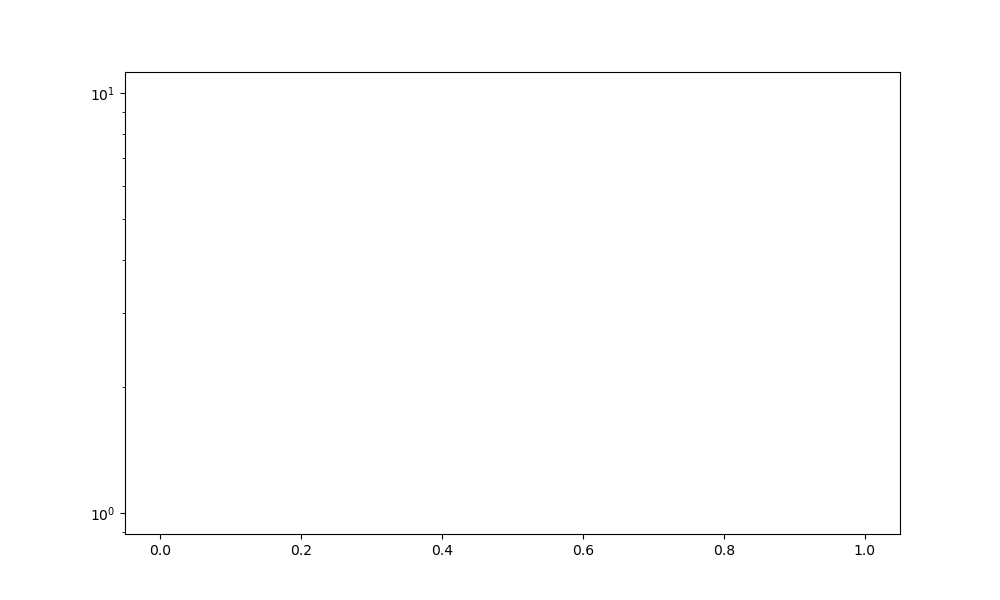

In [159]:
### test distribution of values first - this actually takes a while :(
today = date.today()
todaystr = today.strftime("%y%m%d")
### distribution of gene_scores, for each gene and each pair of MCL clusters - too many possibilities to calculate
all_gene_scores = []
included_pairs = []
distribution_genescores_fig = os.path.join(inputdir, f'custom_gene_scores_distribution.png')
if not os.path.exists(distribution_genescores_fig):
    ### check every MCL cluster vs every other MCL cluster
    for query_cluster in cluster_list:
        query_node_num = len(cluster_to_gene_dict[query_cluster])
        query_gene_list = cluster_to_gene_dict[query_cluster]
        for target_cluster in cluster_list:
            ### skip if same cluster or already seen pair of clusters
            if query_cluster == target_cluster or set([query_cluster, target_cluster]) in included_pairs:
                continue
            target_node_num = len(cluster_to_gene_dict[target_cluster])
            target_gene_list = cluster_to_gene_dict[target_cluster]
            ### now check if there are disassociations between the two MCL clusters
            betweenMCL_dis_edges_df = outside_MCL_gene_disassoc_edges_df[((outside_MCL_gene_disassoc_edges_df['clustersource'] == query_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == target_cluster)) | ((outside_MCL_gene_disassoc_edges_df['clustersource'] == target_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == query_cluster))]
            total_nodes = query_node_num + target_node_num
            ### there may be none, so skip if so (speeds up the process if we don't count zeroes)
            if not len(betweenMCL_dis_edges_df):
                #all_gene_scores = all_gene_scores + [0] * (total_nodes)
                continue
            ### query hits
            for gene in query_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / target_node_num
                all_gene_scores.append(thisgenescore)
            ### target hits
            for gene in target_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / query_node_num
                all_gene_scores.append(thisgenescore)
        #print(len(all_gene_scores))
    ### now visualize the distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    all_gene_scores_np = np.array(all_gene_scores)
    plt.hist(all_gene_scores_np, bins=20)
    plt.yscale('log')
    print("\n\nDistribution of gene scores")
    plt.show()
    fig.savefig(distribution_genescores_fig)
else:
   display(Image(filename=distribution_genescores_fig))
#print(len(all_gene_scores_np))

Empty DataFrame
Columns: [source, target, GeneForce]
Index: []
Error displaying GeneForce distribution. Check the file.
Applying default style...
Applying preferred layout
Applying visual style: GOLDfinder_allassoc


ValueError: Cannot set a DataFrame with multiple columns to the single column shared name

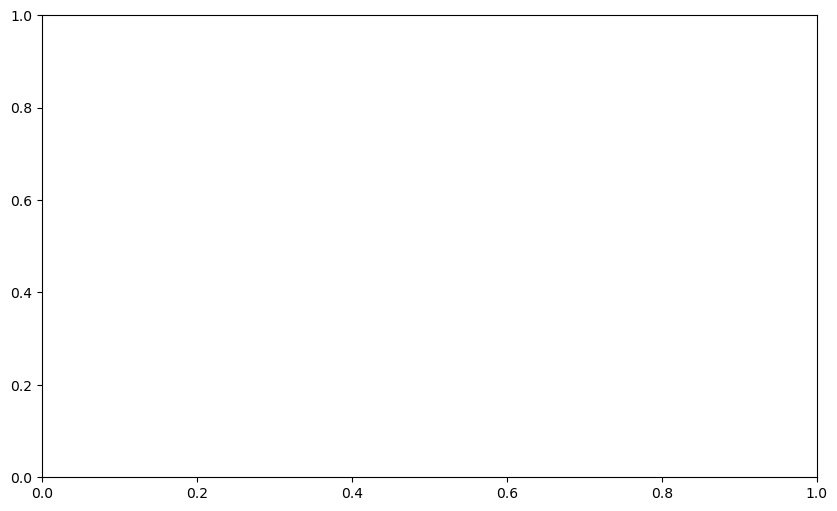

In [160]:
### instead of force, or existing MCL-MCL disassociations, create metric that is based on genes, not pairs of genes (avoids bias between different sizes of MCL clusters)
today = date.today()
todaystr = today.strftime("%y%m%d")
### specify inclusive threshold (>=) accepting a hit in the MCL-MCL disassociations (percentage of genes in MCL cluster that a gene of another MCL cluster is dissassociated with)
disT = 0.5
### specify not-inclusive hit score threshold (>) for showing the MCL-MCL disassociation edges
hitT = 0
specialMCLclusters_dis_edges_dict = {}
index_counter = 0
### save into file to avoid recalculating
specialMCLclusters_dis_edges_table = os.path.join(inputdir, f'custom_specialMCLclusters_dis_edges_table_{disT}_{hitT}.csv')
if not os.path.exists(specialMCLclusters_dis_edges_table):
    included_pairs = []
    ### check every MCL cluster vs every other MCL cluster
    for query_cluster in cluster_list:
        query_node_num = len(cluster_to_gene_dict[query_cluster])
        query_gene_list = cluster_to_gene_dict[query_cluster]
        for target_cluster in cluster_list:
            ### skip if same cluster or already seen pair of clusters
            if query_cluster == target_cluster or set([query_cluster, target_cluster]) in included_pairs:
                continue
            target_node_num = len(cluster_to_gene_dict[target_cluster])
            target_gene_list = cluster_to_gene_dict[target_cluster]
            ### now check if there are disassociations between the two MCL clusters
            betweenMCL_dis_edges_df = outside_MCL_gene_disassoc_edges_df[((outside_MCL_gene_disassoc_edges_df['clustersource'] == query_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == target_cluster)) | ((outside_MCL_gene_disassoc_edges_df['clustersource'] == target_cluster) & (outside_MCL_gene_disassoc_edges_df['clustertarget'] == query_cluster))]
            ### there may be none, so skip if so
            if not len(betweenMCL_dis_edges_df):
                continue
            #print(betweenMCL_dis_edges_df)
            #print(len(betweenMCL_dis_edges_df))
            ### now calculate the metric
            total_nodes = query_node_num + target_node_num
            ### query hits
            query_hits = 0
            for gene in query_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / target_node_num
                if thisgenescore >= disT:
                    query_hits += 1
            ### target hits
            target_hits = 0
            for gene in target_gene_list:
                thisgeneedges_num = len(betweenMCL_dis_edges_df[(betweenMCL_dis_edges_df['source'] == gene) | (betweenMCL_dis_edges_df['target'] == gene)])
                ### what percentage out of the max edges did it have?
                thisgenescore = thisgeneedges_num / query_node_num
                if thisgenescore >= disT:
                    target_hits += 1
            ### total score and weight - how many hits out of all possible hits (or nodes)
            total_score = (query_hits + target_hits) / total_nodes
            ### include it in the edges dict if the score is more than 0
            if total_score > hitT:
                specialMCLclusters_dis_edges_dict[index_counter] = [query_cluster, target_cluster, total_score]
                index_counter += 1
                included_pairs.append(set([query_cluster, target_cluster]))
            #break
        #if len(betweenMCL_dis_edges_df):
            #break
    ### now turn the dict into a dataframe
    specialMCLclusters_dis_edges_df = pd.DataFrame.from_dict(specialMCLclusters_dis_edges_dict, orient='index', columns=['source', 'target', 'GeneForce'])
    specialMCLclusters_dis_edges_df.to_csv(specialMCLclusters_dis_edges_table, index=False)
    print(f"Created file: {specialMCLclusters_dis_edges_table}")
else:
    specialMCLclusters_dis_edges_df = pd.read_csv(specialMCLclusters_dis_edges_table)
print(specialMCLclusters_dis_edges_df)

### visualize distribution of GeneForce values
these_parameters_distribution_geneforces_fig = os.path.join(inputdir, f'custom_GeneForce_distribution_disT{disT}_geneT{hitT}.png')
if not os.path.exists(these_parameters_distribution_geneforces_fig):
    try:
        fig, ax = plt.subplots(figsize=(10, 6))
        specialMCLclusters_dis_edges_df['GeneForce'].plot.hist(bins=20)
        print("\n\nDistribution of GeneForce values")
        fig.savefig(these_parameters_distribution_geneforces_fig)
        plt.show()
    except:
        print("Error displaying GeneForce distribution. Check the file.")
else:
   display(Image(filename=these_parameters_distribution_geneforces_fig))

### now visualize
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_clusterdis_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
apply_visual_style(styles_dict['all_association'])

genebased_cl_cl_disassociation_pairs = list(zip(specialMCLclusters_dis_edges_df['source'],specialMCLclusters_dis_edges_df['target']))
genebased_cl_cl_disassociation_pairs = [list(ele) for ele in genebased_cl_cl_disassociation_pairs]
p4c.add_cy_edges(genebased_cl_cl_disassociation_pairs, edge_type='disassociation')
current_network_name = f'Gene-MCL cluster associations and significant (disT>={disT}, GeneForce>{hitT}) cluster-cluster disassociations'
p4c.rename_network(current_network_name)
p4c.layout_network('force-directed')
### add also GeneForce as info
specialMCLclusters_dis_edges_df['shared name'] = specialMCLclusters_dis_edges_df[['source','target']].agg(' (disassociation) '.join, axis=1) 
print(specialMCLclusters_dis_edges_df)
p4c.load_table_data(specialMCLclusters_dis_edges_df, data_key_column='shared name', table_key_column='shared name', table='edge')
### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
time.sleep(1)
### fix visuals
apply_visual_style(styles_dict['all_assoc_genebased_dissoc'])
### save the figure
outfig_name=f'{todaystr}_GOLDfinder_MCLclusters_disassoc_disT{disT}_geneT{hitT}.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
save_network_image(join(outdir, outfig_name), filetype='JPEG')
print(f"Saving figure in file {outfig_name}")
### save session
outcys_session_name = f'{todaystr}_GOLDfinder_MCLclusters_disassoc_disT{disT}_geneT{hitT}.cys'
p4c.save_session(os.path.join(outdir, outcys_session_name))
print(f"Saving session in file {outcys_session_name}")


## 2: Visualizing MCL association clusters, their members and the cluster-cluster ASSOCIATIONS (multiple networks)
The following code block will first visualize the genes and their association edges to the MCL clusters. Then, it will iteratively visualize the 200 (nrows) most significant associations between MCL clusters in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)
#### Warning: all currently open networks will be deleted before new ones are generated!

In [ ]:
### visualize most significant interactions only or all of them?
onlysignificant = True
### if onlysignificant=True, what is the threshold for the Force value (inclusive)?
force_T = 1.1
### If onlysignificant=False, do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### If onlysignificant=False, how many edges should be visualized at a time? change variable here
nrows = 50

today = date.today()
todaystr = today.strftime("%y%m%d")

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)

if onlysignificant:
    cluster_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    #print(cluster_assoc_edges_df)
    significant_cluster_assoc_edges_df = cluster_assoc_edges_df[cluster_assoc_edges_df['Force'] >= force_T]
    print(significant_cluster_assoc_edges_df)
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['Node1'],significant_cluster_assoc_edges_df['Node2']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
    current_network_name = f'Gene-MCL cluster associations and significant (Force>={force_T}) cluster-cluster associations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### 1 sec delay is necessary here to make sure the selection of edges occurs on the latest network
    time.sleep(1)
    ### fix visuals
    apply_visual_style(styles_dict['all_association'])
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_top_MCLclusters_assoc_T{force_T}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save session
    outcys_session_name = f'{todaystr}_GOLDfinder_top_MCLclusters_assoc_T{force_T}.cys'
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    print(f"Saving session in file {outcys_session_name}")
else:
    ### now add association edges
    index = 0
    cluster_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    ### deal with first network first
    significant_cluster_assoc_edges_df = cluster_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['Node1'],significant_cluster_assoc_edges_df['Node2']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
    current_network_name = f'Gene-MCL cluster associations and top {nrows} cluster-cluster associations'
    p4c.rename_network(current_network_name)
    p4c.layout_network('force-directed')
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_manyclAs_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    time.sleep(1)
    
    ### fix visuals
    apply_visual_style(styles_dict['all_association'])
    
    ### then copy network, remove association edges and repeat
    while nrows * index < len(cluster_assoc_edges_df):
        index+=1
        ### clone network (unfortunately also copies collection name based on network name)
        p4c.clone_network()
        time.sleep(1)
        try:
            significant_cluster_edges_df = cluster_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
            current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) cluster-cluster associations'
        except:
            significant_cluster_edges_df = cluster_assoc_edges_df.iloc[index*nrows:, :]
            current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} cluster-cluster associations'
        if len(significant_cluster_edges_df) == 0:
            break
        #### remove current edges
        p4c.rename_network(current_network_name)
        p4c.select_edges('association', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
        p4c.delete_selected_edges()
        ### then generate new ones
        sign_cl_cl_association_pairs = list(zip(significant_cluster_edges_df['Node1'],significant_cluster_edges_df['Node2']))
        sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
        p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='association')
        ### at this point decide if the layout should be recalculated or not
        if not keep_node_positions:
            p4c.layout_network('force-directed')
        ### fix visuals
        apply_visual_style(styles_dict['all_association'])
        ### save the figure
        outfig_name= f'{todaystr}_allassoc_manyclAs_networks_{index}.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        save_network_image(join(outdir, outfig_name), filetype='JPEG')
        print(f"Saving figure in file {outfig_name}")
    
    print("Applied custom style (GOLDfinder_allassoc) to all networks")
    
    ### save session - change path as needed
    today = date.today()
    todaystr = today.strftime("%y%m%d")
    if not keep_node_positions:
        outcys_session_name = f'{todaystr}_allassoc_manyclAs_networks_difflayout.cys'
    else:
        outcys_session_name = f'{todaystr}_allassoc_manyclAs_networks_samelayout.cys'
    print(f"Saving session in file {outcys_session_name}")
    p4c.save_session(os.path.join(outdir, outcys_session_name)) 
### show example legend
example2 = os.path.join(examples_dir, '2_visualisation_legend.png')
try:
    display(Image(filename=example2))
except:
    print("Error displaying example legend")
print('\nDone')

Applying default style...
Applying preferred layout
Empty DataFrame
Columns: [Node1, Node2, Force, pair_type, Node1_ass_degree, Node2_ass_degree, max_ass_degree]
Index: []


/tmp/ipykernel_7554/857160992.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)


Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_GOLDfinder_top_MCLclusters_assoc_T1.1.jpeg
Saving figure in file 241220_GOLDfinder_top_MCLclusters_assoc_T1.1.jpeg
Saving session in file 241220_GOLDfinder_top_MCLclusters_assoc_T1.1.cys
Error displaying example legend

Done


## 3: Visualizing MCL association clusters, their members and the gene-gene ASSOCIATIONS happening across MCL clusters (multiple networks)
The following code block will first visualize the genes and their association edges to the MCL clusters. Then, it will iteratively visualize the 1000 (nrows) most significant associations between genes that do NOT belong in the same MCL cluster, in one network at a time. Depending on the keep_node_positions variable, the layout algorithm will be reapplied with each iteration (False) or the nodes will keep their position as it was in the first visualization (True)
#### Warning: all currently open networks will be deleted before new ones are generated!

In [ ]:
### do we want to keep the node positions stable or not? change variable here
keep_node_positions = False
### how many edges should be visualized at a time? change variable here
nrows = 1000

today = date.today()
todaystr = today.strftime("%y%m%d")

### import associations first
### deleting existing networks to start over
p4c.delete_all_networks()
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(all_assoc_nodes_df, gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)

### now add outside of MCL cluster gene-gene association edges
index = 0

outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)

### deal with first network first
significant_cluster_assoc_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
current_network_name = f'Gene-MCL cluster associations and top {nrows} gene-gene associations across MCL clusters'
p4c.rename_network(current_network_name)
p4c.layout_network('force-directed')
### save the figure
outfig_name= f'{todaystr}_allassoc_extraMCLgenegene_networks_{index}.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
save_network_image(join(outdir, outfig_name), filetype='JPEG')
print(f"Saving figure in file {outfig_name}")
time.sleep(1)

### fix visuals
apply_visual_style(styles_dict['all_association'])

### then copy network, remove association edges and repeat
while nrows * index < len(outside_MCL_gene_assoc_edges_df):
    #print(index)
    index+=1
    ### clone network (unfortunately also copies collection name based on network name)
    p4c.clone_network()
    time.sleep(1)
    try:
        significant_cluster_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:(index+1)*nrows, :]
        current_network_name = f'Gene-MCL cluster associations and next {nrows} ({(index*nrows) + 1} to {(index+1)* nrows}) gene-gene associations across MCL clusters'
    except:
        significant_cluster_edges_df = outside_MCL_gene_assoc_edges_df.iloc[index*nrows:, :]
        current_network_name = f'Gene-MCL cluster associations and final {len(significant_cluster_edges_df)} gene-gene associations across MCL clusters'
    if len(significant_cluster_edges_df) == 0:
        break
    #### remove current edges
    p4c.rename_network(current_network_name)
    p4c.select_edges('weak_association', by_col='interaction', preserve_current_selection=False, network=current_network_name)#, network='My Network')
    p4c.delete_selected_edges()
    ### then generate new ones
    sign_cl_cl_association_pairs = list(zip(significant_cluster_edges_df['source'],significant_cluster_edges_df['target']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
    ### at this point decide if the layout should be recalculated or not
    if not keep_node_positions:
        p4c.layout_network('force-directed')
    ### fix visuals
    apply_visual_style(styles_dict['all_association'])
    ### save the figure
    outfig_name= f'{todaystr}_allassoc_extraMCLgenegene_networks_{index}.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")


print("Applied custom style (GOLDfinder_allassoc) to all networks")

### save session - change path as needed
if not keep_node_positions:
    outcys_session_name = f'{todaystr}_allassoc_extraMCLgenegene_networks_difflayout.cys'
else:
    outcys_session_name = f'{todaystr}_allassoc_extraMCLgenegene_networks_samelayout.cys'
print(f"Saving session in file {outcys_session_name}")
p4c.save_session(os.path.join(outdir, outcys_session_name))
### show example legend
example3 = os.path.join(examples_dir, '3_visualisation_legend.png')
try:
    display(Image(filename=example3))
except:
    print("Error displaying example legend")
print('\nDone')

Applying default style...
Applying preferred layout


/tmp/ipykernel_7554/2228705106.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)


Saving figure in file 241220_allassoc_extraMCLgenegene_networks_0.jpeg
Saving figure in file 241220_allassoc_extraMCLgenegene_networks_0.jpeg
Applying visual style: GOLDfinder_allassoc
Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_allassoc_extraMCLgenegene_networks_1.jpeg
Saving figure in file 241220_allassoc_extraMCLgenegene_networks_1.jpeg
Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_allassoc_extraMCLgenegene_networks_2.jpeg
Saving figure in file 241220_allassoc_extraMCLgenegene_networks_2.jpeg
Applied custom style (GOLDfinder_allassoc) to all networks
Saving session in file 241220_allassoc_extraMCLgenegene_networks_difflayout.cys
Error displaying example legend

Done


## 4: Visualizing all associations between genes 

The following code block will visualize the genes and their association edges to other genes. 

#### Warning: all currently open networks will be deleted before new ones are generated!

In [ ]:
### deleting existing networks to start over
p4c.delete_all_networks()

today = date.today()
todaystr = today.strftime("%y%m%d")

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
#print(gene_assoc_edges_df)
p4c.create_network_from_data_frames(gene_nodes_df,gene_assoc_edges_df , title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
apply_visual_style(styles_dict['all_association'])
### save the figure
outfig_name= f'{todaystr}_GOLDfinder_allassoc.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
save_network_image(join(outdir, outfig_name), filetype='JPEG')
print(f"Saving figure in file {outfig_name}")
### save the session
outcys_session_name = f'{todaystr}_GOLDfinder_allassoc.cys'
print(f"Saving session in file {outcys_session_name}")
p4c.save_session(os.path.join(outdir, outcys_session_name))



/home/agavriil/miniconda3/envs/goldfinder/lib/python3.10/site-packages/py4cytoscape/networks.py:1120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if not interaction_type_list in edges.columns: edges[interaction_type_list] = 'interacts with'


Applying default style...
Applying preferred layout
Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_GOLDfinder_allassoc.jpeg
Saving figure in file 241220_GOLDfinder_allassoc.jpeg
Saving session in file 241220_GOLDfinder_allassoc.cys


{}

## 5: Visualizing all associations between genes belonging to the same MCL cluster

The following code block will visualize the genes and their association edges to other genes only if both genes belong to the same MCL cluster. The nodes will be coloured according to MCL cluster membership. If the addamong variable is set to True, then also the among MCL cluster gene-gene associations will be drawn, which will be more transparent, without affecting the layout.

#### Warning: all currently open networks will be deleted before new ones are generated!

In [ ]:
### do you want to add also the amongMCLcluster associations? ---- this is what is used to create the GOLDfinder comparison figure. First visualize all within MCL gene-gene associations. Then add the among MCL gnee-gene asociations (transparency 20). Then add the COINfinder network as in a code block further below, and copycat the layout of this one.
addamong = True
### deleting existing networks to start over
p4c.delete_all_networks()

today = date.today()
todaystr = today.strftime("%y%m%d")

### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
#print(gene_assoc_edges_df)
p4c.create_network_from_data_frames(gene_nodes_df,gene_assoc_edges_df[gene_assoc_edges_df['withinMCL'] == True] , title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
apply_visual_style(styles_dict['all_association'])
### save the figure
outfig_name= f'{todaystr}_GOLDfinder_allassocwithincMCLcluster.jpeg'
# for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
save_network_image(join(outdir, outfig_name), filetype='JPEG')
print(f"Saving figure in file {outfig_name}")
### save this as basic figure
outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithincMCLcluster.cys'
print(f"Saving session in file {outcys_session_name}")
p4c.save_session(os.path.join(outdir, outcys_session_name))


if addamong:
    outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)
    significant_cluster_assoc_edges_df = outside_MCL_gene_assoc_edges_df#.iloc[index*nrows:(index+1)*nrows, :]
    sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
    sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
    p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_allassocwithincMCLcluster_plusAmong.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(outdir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save this as basic figure
    outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithincMCLcluster_plusAmong.cys'
    print(f"Saving session in file {outcys_session_name}")
    p4c.save_session(os.path.join(outdir, outcys_session_name))
    


Applying default style...
Applying preferred layout
Applying visual style: GOLDfinder_allassoc
Saving figure in file 241220_GOLDfinder_allassocwithincMCLcluster.jpeg
Saving figure in file 241220_GOLDfinder_allassocwithincMCLcluster.jpeg
Saving session in file 241220_GOLDfinder_allassocwithincMCLcluster.cys


/tmp/ipykernel_7554/1797028084.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outside_MCL_gene_assoc_edges_df.sort_values('Force', ascending=False, inplace=True)


Saving figure in file 241220_GOLDfinder_allassocwithincMCLcluster_plusAmong.jpeg
Saving figure in file 241220_GOLDfinder_allassocwithincMCLcluster_plusAmong.jpeg
Saving session in file 241220_GOLDfinder_allassocwithincMCLcluster_plusAmong.cys


## Special case: GOLDfinder-COINfinder comparison
### Data import
The following code block imports all information necessary from the COINfinder results files and prepares the data in a format ready to be visualized. No network is generated in cytoscape yet.

In [148]:
### don't run by default
if False:
    coinfinder_dir = '/media/hdd_2tb/side_projects/amycolatopsis_pangenome/emil_GOLDfinder_project/precomputed_results/coinfinder_for_comparison'
    
    coin_association_clusters_file = os.path.join(coinfinder_dir, 'coinfinder_clusters_no_duplicates.txt')
    coin_associated_pairs_file = os.path.join(coinfinder_dir, 'coinfinder_result.tsv')
    
    ### get info from coinfinder files
    ### get info from coinfinder_result file
    coin_assoc_pairs_df = pd.read_csv(coin_associated_pairs_file, sep='\t')
    coin_assoc_pairs_df.rename(columns={'Source':'source', 'Target':'target'}, inplace=True)
    #print(coin_assoc_pairs_df)
    coin_gene1_df = coin_assoc_pairs_df[['source']]
    coin_gene2_df = coin_assoc_pairs_df[['target']]
    coldict = {'source':'Gene', 
               'target':'Gene'}
    coin_gene1_df.rename(columns=coldict, inplace=True)
    coin_gene2_df.rename(columns=coldict, inplace=True)
    coin_gene_nodes_df = pd.concat([coin_gene1_df, coin_gene2_df])
    coin_gene_nodes_df.drop_duplicates(inplace=True)
    coin_gene_nodes_df['id'] = coin_gene_nodes_df['Gene']
    coin_gene_nodes_df['isgene'] = True
    coin_genes_list = list(set(coin_gene_nodes_df['Gene'].tolist()))
    
    
    ### get info from coin_clusters file
    coin_gene_to_cluster_dict = {}
    coin_cluster_list = []
    with open(coin_association_clusters_file, 'r') as infile:
        new_cluster = False
        for line in infile.readlines():
            line = line.rstrip()
            line = line.rstrip(',')
            if line.startswith('>'):
                cluster_num = line[1:].split(",")[0]
                coin_cluster_list.append('cl_%s' %(cluster_num))
                continue
            if line in coin_gene_to_cluster_dict.keys():
                if coin_gene_to_cluster_dict[line] != 'cl_%s' %(cluster_num):
                    print("ERROR: gene with multiple cluster assingments detected: %s" %(line))
                    exit()
            coin_gene_to_cluster_dict[line] = 'cl_%s' %(cluster_num)
    
    ### add cluster info to gene_nodes_df
    coin_gene_nodes_df['Cluster'] = coin_gene_nodes_df['Gene'].map(coin_gene_to_cluster_dict)
    print("Checking for empty cells in node table...")
    print("Found:", coin_gene_nodes_df.isnull().sum().sum())
    coin_gene_nodes_df.fillna('', inplace=True)
    
    ### generate coin_gene_to_cluster_edges_df
    coin_gene_to_cluster_edges_df = coin_gene_nodes_df.loc[coin_gene_nodes_df['Cluster'] != ''][['Gene', 'Cluster']]
    coin_rename_cols_dict = {'Gene': 'source', 'Cluster': 'target'}
    coin_gene_to_cluster_edges_df.rename(columns=coin_rename_cols_dict, inplace=True)
    coin_cluster_list = list(set(coin_gene_to_cluster_edges_df['target'].tolist()))
    coin_cluster_nodes_df = pd.DataFrame(coin_cluster_list)
    coin_cluster_nodes_df.rename(columns={0:"Gene"}, inplace=True)
    coin_cluster_nodes_df['isgene'] = False
    coin_cluster_nodes_df['Cluster'] = coin_cluster_nodes_df['Gene']

    coin_gene_to_cluster_edges_df['Cluster_num'] = coin_gene_to_cluster_edges_df['target'].map(lambda x: int(x.replace('cl_','')))
    coin_nodes_list = list(set(coin_genes_list + coin_cluster_list))
    coin_gene_nodes_df['Cluster_num'] = coin_gene_nodes_df['Cluster'].map(lambda x: int(x.replace('cl_','')) if x != '' else  0)
    
    coin_all_assoc_nodes_df = pd.concat([coin_gene_nodes_df, coin_cluster_nodes_df])
    coin_all_assoc_nodes_df = coin_all_assoc_nodes_df.set_index('Gene').reindex(index=coin_nodes_list).fillna('').reset_index()
    coin_all_assoc_nodes_df['id'] = coin_all_assoc_nodes_df['Gene']
    #print(coin_all_assoc_nodes_df)
    
    ### get info for gene-gene associations happening across MCL clusters
    def withinMCLconditions(row):
        if row['clustersource'] == row['clustertarget']:
            return True
        else:
            return False
    coin_assoc_pairs_df['clustersource'] = coin_assoc_pairs_df['source'].map(coin_gene_to_cluster_dict)
    coin_assoc_pairs_df['clustertarget'] = coin_assoc_pairs_df['target'].map(coin_gene_to_cluster_dict)
    coin_assoc_pairs_df['withinMCL'] = coin_assoc_pairs_df.apply(withinMCLconditions, axis=1)
    coin_outside_MCL_gene_assoc_edges_df =coin_assoc_pairs_df[coin_assoc_pairs_df['withinMCL'] == False]
    
    coin_sign_cl_cl_association_pairs_all = list(zip(coin_outside_MCL_gene_assoc_edges_df['source'], coin_outside_MCL_gene_assoc_edges_df['target']))
    coin_sign_cl_cl_association_pairs_all = list(chain.from_iterable([list(ele) for ele in coin_sign_cl_cl_association_pairs_all]))

    #print(coin_gene_to_cluster_edges_df)
    #print(coin_cluster_nodes_df)
    #print(coin_gene_nodes_df)
    #print(coin_assoc_pairs_df)
    
    combo_coin_all_assoc_nodes_df = coin_all_assoc_nodes_df.copy()
    combo_coin_all_assoc_nodes_df['Gene'] = coin_all_assoc_nodes_df['Gene'].map(lambda x: x.replace('cl_','c_cl_'))
    combo_coin_all_assoc_nodes_df['id'] = combo_coin_all_assoc_nodes_df['Gene']
    combo_coin_all_assoc_nodes_df['algorithm'] = np.where(combo_coin_all_assoc_nodes_df['isgene'] == False, 'coin', '')
    combo_coin_gene_to_cluster_edges_df = coin_gene_to_cluster_edges_df.copy()
    combo_coin_gene_to_cluster_edges_df['target'] = coin_gene_to_cluster_edges_df['target'].map(lambda x: x.replace('cl_','c_cl_'))
    combo_gold_all_assoc_clusterdis_nodes_df = all_assoc_clusterdis_nodes_df.copy()
    combo_gold_all_assoc_clusterdis_nodes_df['Gene'] = all_assoc_clusterdis_nodes_df['Gene'].map(lambda x: x.replace('cl_','g_cl_'))
    combo_gold_all_assoc_clusterdis_nodes_df['id'] = combo_gold_all_assoc_clusterdis_nodes_df['Gene']
    combo_gold_all_assoc_clusterdis_nodes_df['algorithm'] = np.where(combo_gold_all_assoc_clusterdis_nodes_df['isgene'] == False, 'gold', '')
    combo_gold_gene_to_cluster_edges_df = gene_to_cluster_edges_df.copy()
    combo_gold_gene_to_cluster_edges_df['target'] = gene_to_cluster_edges_df['target'].map(lambda x: x.replace('cl_','g_cl_'))
    
    
    
    print("\nDone")

### Figure generation: GOLDfinder - COINfinder comparison

In [149]:
### don't run by default
if False:

    ### Creating Fig1 of GOLDfinder manuscript: GOLDfinder-COINfinder comparison
    addamong = True
    addandcopyCOINfinder = True

    today = date.today()
    todaystr = today.strftime("%y%m%d")

    ### start from GOLDfinder
    ### deleting existing networks to start over
    p4c.delete_all_networks()

    ### make associations network inlcuding MCL clusters
    collection_title = "GOLDfinder results"
    p4c.create_network_from_data_frames(gene_nodes_df, within_MCL_gene_assoc_edges_df, title="GOLDfinder gene association network", collection=collection_title)
    p4c.layout_network('force-directed')
    apply_visual_style(styles_dict['manuscript_comparison'])
    ### save the figure
    outfig_name= f'{todaystr}_GOLDfinder_allassocwithinMCLcluster.jpeg'
    # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
    save_network_image(join(coinfinder_dir, outfig_name), filetype='JPEG')
    print(f"Saving figure in file {outfig_name}")
    ### save the session
    outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithinMCLcluster.cys'
    print(f"Saving session in file {outcys_session_name}")
    p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))

    ### now add the among MCL clusters associations
    if addamong:
        significant_cluster_assoc_edges_df = coin_outside_MCL_gene_assoc_edges_df
        sign_cl_cl_association_pairs = list(zip(significant_cluster_assoc_edges_df['source'],significant_cluster_assoc_edges_df['target']))
        sign_cl_cl_association_pairs = [list(ele) for ele in sign_cl_cl_association_pairs]
        p4c.add_cy_edges(sign_cl_cl_association_pairs, edge_type='weak_association')
        ### save the figure
        outfig_name= f'{todaystr}_GOLDfinder_allassocwithinMCLcluster_plusAmong.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        save_network_image(join(coinfinder_dir, outfig_name), filetype='JPEG')
        ### save the session
        outcys_session_name = f'{todaystr}_GOLDfinder_allassocwithinMCLcluster_plusAmong.cys'
        print(f"Saving session in file {outcys_session_name}")
        p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))
    if addandcopyCOINfinder:
        ### now make a new network with COINfinder associations
        collection_title = "COINfinder results"
        p4c.create_network_from_data_frames(combo_coin_all_assoc_nodes_df, combo_coin_gene_to_cluster_edges_df, title="COINfinder gene association network", collection=collection_title)
        p4c.layout_copycat(source='GOLDfinder gene association network',target='COINfinder gene association network')
        apply_visual_style(styles_dict['manuscript_comparison'])
        ### save the figure
        outfig_name= f'{todaystr}_copycat_COINfinder_allassocwithinMCLcluster_plusAmong.jpeg'
        # for more options see here: https://py4cytoscape.readthedocs.io/en/latest/reference/generated/py4cytoscape.network_views.export_image.html
        save_network_image(join(coinfinder_dir, outfig_name), filetype='JPEG')
        ### save the session
        outcys_session_name = f'{todaystr}_copycat_COINfinder_allassocwithinMCLcluster_plusAmong.cys'
        print(f"Saving session in file {outcys_session_name}")
        p4c.save_session(os.path.join(coinfinder_dir, outcys_session_name))
    print('\nDone')

In [150]:
### make combined network of both GOLD and COIN -----   this is what we use to add the COINfinder network after the GOLDfinder network (all within MCL-gene-gene associations plus added among associations)
#### after importing, copycat layout of GOLDfinder and use the same style


'''
### make associations network inlcuding MCL clusters
collection_title = "GOLDfinder results"
p4c.create_network_from_data_frames(combo_gold_all_assoc_clusterdis_nodes_df, combo_gold_gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)
p4c.layout_network('force-directed')
p4c.set_visual_style('GOLDfinder_allassoc')
'''

'\n### make associations network inlcuding MCL clusters\ncollection_title = "GOLDfinder results"\np4c.create_network_from_data_frames(combo_gold_all_assoc_clusterdis_nodes_df, combo_gold_gene_to_cluster_edges_df, title="GOLDfinder gene association network", collection=collection_title)\np4c.layout_network(\'force-directed\')\np4c.set_visual_style(\'GOLDfinder_allassoc\')\n'